Rafał Nowak
# Numerical Optimization
## Problem set 2 (14 points)

**Submission deadline**: Thursday, 12.11.2020

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

Mateusz Markiewicz 298653

In [1]:
import numpy as np
import numpy.linalg as npl
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.linalg import hilbert
from scipy.optimize import linprog

## Problem 2.1 (5 pts)

In the problem 1.3, your implementation may have done a lot of inverse operations.

This task is to implement *revised simplex algorithm* with incremental A inverse computation 
by using the **[Sherman-Morrison](https://www.wikiwand.com/en/Sherman%E2%80%93Morrison_formula)** formula for keeping track of the inverse matrix.

Your program will be graded based on how fast it is.
You should expect to see a factor 10-20 speedup depending on the problem instance.

```julia
function revised_simplex_method(I, c, A, b)
    # write your code here
    # ...
    return # v, x
end
```

*Hint*. Please test your code with attached `npz` file (see problem 1.3).<br/>
Repeat the tests with `method = revised_simplex_method` and compare the time elapsed for both methods.

Instead of calculating the inverse of the B matrix every turn, we can update the previous inverse of the B matrix.

We can use Sherman-Morrison formula:
$(A+uv^T)^{-1}=A^{-1}-\frac{A^{-1}uv^TA^{-1}}{1+v^TA^{-1}u}$

In our case, u is the vector that will enter the basis minus the vector that is leaving the basis, and v is a vector of zeros, with "1" on k-th position, where k is the position of the vector leaving the basis.

In [2]:
def simplex_method(I, c, A, b):
    m, n = A.shape
    N = np.array([i for i in range(n) if i not in I])
    I = np.array(I)
    b = b.reshape(-1,1)
    c = c.reshape(-1,1)
    
    while True:
        B = A[:,I]
        B_inv = inv(B)
        xb = B_inv @ b
        assert np.all(xb>=0), xb
        rn = (c[N].T - c[I].T @ B_inv @ A[:,N])[0]
        if np.all(rn>=0):
            break
        ii = np.argmin(rn)
        i = N[ii]
        y = B_inv @ A[:,i].reshape(-1,1)
        if np.all(y<0):
            return -np.inf, np.zeros(n)
        y += (y==0) * 1e-20
        alphas = xb/np.max((y,np.ones_like(y)*1e-15),axis=0)
        ji = alphas.argmin()
        j = I[ji]
        I[ji],N[ii] = i,j
    
    x = np.zeros(n).reshape(-1,1)
    x[I] = xb
    v = (c.reshape(1,-1) @ x)[0][0]
    return v, x.reshape(-1,)

In [144]:
def revised_simplex_method(I, c, A, b):
    m, n = A.shape
    N = np.array([i for i in range(n) if i not in I])
    I = np.array(I)
    b = b.reshape(-1,1)
    c = c.reshape(-1,1)
    
    B = A[:,I]
    B_inv = inv(B)
    
    while True:
        xb = B_inv @ b
        assert np.all(xb>=0), xb
        rn = (c[N].T - c[I].T @ B_inv @ A[:,N])[0]
        if np.all(rn>=0):
            break
        ii = np.argmin(rn)
        i = N[ii]
        u = A[:,i].copy().reshape(-1,1)
        y = B_inv @ u
        if np.all(y<0):
            return -np.inf, np.zeros(n)
        alphas = xb/np.max((y,np.ones_like(y)*1e-15),axis=0)
        ji = alphas.argmin()
        j = I[ji]
        I[ji],N[ii] = i,j
        u -= A[:,j].reshape(-1,1)
        
        B_inv_u = B_inv @ u
        
        denominator = 1+B_inv_u[ji]
        nominator = B_inv_u @ B_inv[ji,:].reshape(1,m)
        B_inv -= nominator/denominator

        
    x = np.zeros(n).reshape(-1,1)
    x[I] = xb
    v = (c.reshape(1,-1) @ x)[0][0]
    return v, x.reshape(-1,)

In [4]:
tests = np.load('simplex_test_data.npz',allow_pickle=True)['data'].item()

In [5]:
for i,test in tests.items():
    A,b,c,f,x,I = test['A'], test['b'], test['c'], test['f'], test['x'], test['I']
    if i>=31:
        # In tests 31-40 x size is 51, where A shape is (20,50)
        x = x[:-1]
    t0 = time.time()
    sf,sx = simplex_method(I,c,A,b)
    t_simplex = time.time()-t0
    t0 = time.time()
    sf,sx = revised_simplex_method(I,c,A,b)
    t_revised_simplex = time.time()-t0
    print(f'Test #{i}')
    print(f'Simplex time: {np.round(t_simplex,5)}, revised simplex time: {np.round(t_revised_simplex,5)}')
    if np.isclose(f,sf) and np.allclose(x,sx):
        print('Correct!')
    else:
        #print(f'correct solution: {f}, for x: {x}\nmy solution: {sf}, for x: {sx}')
        print(f'F absolute difference: {np.round(np.abs(f-sf),5)}, relative error: {np.round((np.abs(f-sf)/np.abs(f))*100,3)}%, x vectors distance: {np.round(np.sum((x-sx)**2),5)}, dist(x-my_x)/||x||: {np.round(np.sqrt(np.sum((x-sx)**2))/np.sqrt(np.sum(x**2)),5)}')
    print()

Test #1
Simplex time: 0.05754, revised simplex time: 0.0
Correct!

Test #2
Simplex time: 0.104, revised simplex time: 0.002
Correct!

Test #3
Simplex time: 0.00099, revised simplex time: 0.0
Correct!

Test #4
Simplex time: 0.0, revised simplex time: 0.00099
Correct!

Test #5
Simplex time: 0.001, revised simplex time: 0.0
Correct!

Test #6
Simplex time: 0.0, revised simplex time: 0.0
Correct!

Test #7
Simplex time: 0.001, revised simplex time: 0.0
Correct!

Test #8
Simplex time: 0.0, revised simplex time: 0.0
Correct!

Test #9
Simplex time: 0.001, revised simplex time: 0.001
Correct!

Test #10
Simplex time: 0.0, revised simplex time: 0.00101
Correct!

Test #11
Simplex time: 0.07781, revised simplex time: 0.0
Correct!

Test #12
Simplex time: 0.0, revised simplex time: 0.00499
Correct!

Test #13
Simplex time: 0.00101, revised simplex time: 0.0
Correct!

Test #14
Simplex time: 0.00096, revised simplex time: 0.001
Correct!

Test #15
Simplex time: 0.00202, revised simplex time: 0.001
Correct

### Larger tests

In [145]:
m,n = 1000,25000
A = np.random.randint(0,100000,(m,n))
A[:,:m] = np.eye(m)

In [146]:
b = np.random.randint(0,100000,(m,1))

In [147]:
c = np.random.randint(-100,100,(n,1))
c[:m,:] = np.zeros((m,1))

In [148]:
I = np.arange(m)

In [149]:
t0 = time.time()
f,_ = simplex_method(I, c, A, b)
t1 = time.time()-t0
t0 = time.time()
f2,_ = revised_simplex_method(I, c, A, b)
t2 = time.time() - t0

In [150]:
print(f'Simplex answare: {np.round(f,5)}, revised simplex answare: {np.round(f2,5)}')
print(f'Simplex time: {np.round(t1,5)}, revised simplex time: {np.round(t2,5)}')

Simplex answare: -2.68259, revised simplex answare: -2.68259
Simplex time: 10.64748, revised simplex time: 10.38245


As we can see the accuracy of the new solution stays the same. The time performance is a bit better, but the difference is insignificant. I think this is because I used the inversing function from the NumPy module, which is well-optimized. Comparing own implementation of matrix inversion with the incremental update would probably lead to much bigger differences in time performance.

---

## Problem 2.2 (6 pts)

Assume have a~set of $N$ noisy measurements $(x_i, \tilde y_i)\in\mathbb R^2$ onto which we would like to to fit a line $y=ax+b$. This task can be expressed by the following optimization problem in $L_2$ norm:
$$ \min_{a,b} \sum_{i=1}^N \left(a x_i + b - \tilde y_i\right)^2 = \min_{a,b} \left\| J \begin{pmatrix}a\\b\end{pmatrix} - \tilde y \right\|_2^2,$$
where $\|\cdot\|_2$ means the $L_2$ norm.

One can check that the optimal solution can be obtained by solving the linear system
$$ J^T J \begin{pmatrix}a\\b\end{pmatrix} = J^T \tilde y. $$

* (1 pt) Generate the problem data. Take $N=30, 50, 100$ points in the interval $[0,5]$ and generate the true outputs $y_i = a x_i + b$ for some $a,b \in R$; for example take $a=3, b=4$. Add Gaussian noise $~N(0,1)$ to get the noisy measurements $\tilde y_i$ and plot the results.
* (3 pts) Compute the matrix $J$ and solve the problem using your implementation of Gaussian elimination (see problem 1.1). Plot the obtained line in the same graph as the measurements. 
* (2 pts) Next use any implementation (like `np.linalg.solve`) instead of your Gaussian elimination. Compare the resulting const function values.
* (1 pt) Finally, add some outliers to the data and plot the results (single graph with measurements and solution line).

### Data

In [188]:
N = 50
a = 3
b = 4

In [189]:
X = np.random.rand(N)*5
Y = a*X + b
Y_tilde = Y + np.random.randn(N)

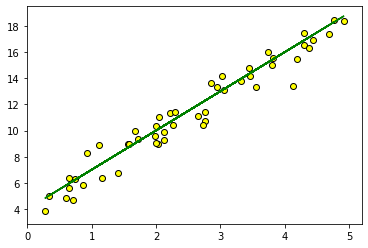

In [190]:
plt.plot(X,Y, c='green')
plt.scatter(X,Y_tilde, c='yellow', edgecolors='black')
plt.show()

### My Gaussian elimination

In [191]:
def solve(A,b):
    n = A.shape[0]
    A = np.hstack((A,b.reshape(n,1))).astype(np.float64)
    for i in range(n-1):
        if A[i][i] == 0:
            k = np.argmax(A[i:,i])
            assert A[k][i] != 0
            A[i],A[k] = np.copy(A[k]), np.copy(A[i])
        for j in range(i+1,n):
            a = A[j][i]/A[i][i]
            A[j] -= a*A[i]
    for i in range(n-1,-1,-1):
        assert A[i][i] != 0
        A[i] /= A[i][i]
        for j in range(i):
            A[j] -= A[j][i]*A[i]
    return A[:,-1]

In [192]:
J = np.hstack((X.reshape(N,1),np.ones((N,1))))

In [193]:
a_my_gaussian, b_my_gaussian = solve(J.T@J, J.T@Y_tilde)
a_my_gaussian, b_my_gaussian

(2.9382404915115825, 3.890558783748058)

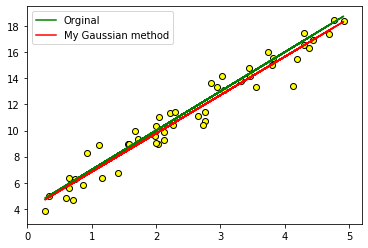

In [194]:
plt.plot(X, Y, c='green', label = 'Orginal')
plt.plot(X, X*a_my_gaussian+b_my_gaussian, c='red', label = 'My Gaussian method')
plt.scatter(X, Y_tilde, c='yellow', edgecolors='black')
plt.legend()
plt.show()

### Numpy's Gaussian elimination

In [195]:
a_npl_gaussian, b_npl_gaussian = npl.solve(J.T@J, J.T@Y_tilde)
a_npl_gaussian, b_npl_gaussian

(2.9382404915115825, 3.8905587837480615)

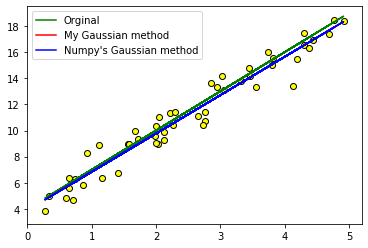

In [196]:
plt.plot(X, Y, c='green', label = 'Orginal')
plt.plot(X, X*a_my_gaussian+b_my_gaussian, c='red', label = 'My Gaussian method')
plt.plot(X, X*a_npl_gaussian+b_npl_gaussian, c='blue', label = "Numpy's Gaussian method")
plt.scatter(X, Y_tilde, c='yellow', edgecolors='black')
plt.legend()
plt.show()

In [197]:
print(f'Orginal a,b: ({a, b})\nmy Gaussian result: ({a_my_gaussian, b_my_gaussian})\nnumpys Gaussian result: ({a_npl_gaussian, b_npl_gaussian})')

Orginal a,b: ((3, 4))
my Gaussian result: ((2.9382404915115825, 3.890558783748058))
numpys Gaussian result: ((2.9382404915115825, 3.8905587837480615))


In [198]:
my_cost = np.sum((X*a_my_gaussian+b_my_gaussian - Y_tilde)**2)
numpy_cost = np.sum((X*a_npl_gaussian+b_npl_gaussian - Y_tilde)**2)
org_cost = np.sum((Y-Y_tilde)**2)
print(f'Orginal cost: {org_cost}\nmy cost: {my_cost}\nnumpys cost: {numpy_cost}')

Orginal cost: 44.49248688564277
my cost: 40.68058237500955
numpys cost: 40.68058237500955


### Data with outliers

In [199]:
Y_with_outliers = Y_tilde.copy() + (np.random.randn(N)*5)*(np.random.rand(N) > 0.90)

In [200]:
a_my_gaussian, b_my_gaussian = solve(J.T@J, J.T@Y_with_outliers)
a_my_gaussian, b_my_gaussian

(2.6567910828675236, 4.815420801049331)

In [201]:
a_npl_gaussian, b_npl_gaussian = npl.solve(J.T@J, J.T@Y_with_outliers)
a_npl_gaussian, b_npl_gaussian

(2.6567910828675254, 4.8154208010493305)

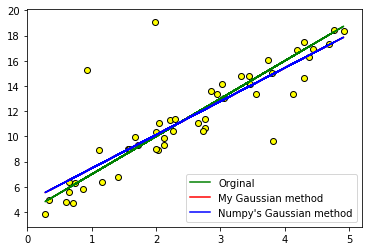

In [202]:
plt.plot(X, Y, c='green', label = 'Orginal')
plt.plot(X, X*a_my_gaussian+b_my_gaussian, c='red', label = 'My Gaussian method')
plt.plot(X, X*a_npl_gaussian+b_npl_gaussian, c='blue', label = "Numpy's Gaussian method")
plt.scatter(X, Y_with_outliers, c='yellow', edgecolors='black')
plt.legend()
plt.show()

Accuracy of my and numpy's implementation of Gaussian method are the same (for those examples). They works quite well for this problem, even having some outliers in the data.

---

## Problem 2.3 (3 pts)

In this problem you are going to fit a line to the set of measurements, but this time with $L_1$ norm, i.e.
$$ \min_{a,b} \sum_{i=1}^{N} |a x_i + b - y_i|. $$
which is not diffentiable. Use some slack variables $s_1, s_2, \ldots, s_N$ and reformulate the problem
into the form
$$
\begin{alignat}{2}
                   & \min_{a,b,s} \sum_i s_i,\\
\text{s.t.} \qquad & -s_i \leq ax_i+b-y_i \leq s_i, \qquad & i=1,2,\ldots, N,\\
                   & s_i \geq 0,                           & i=1,2,\ldots, N.
\end{alignat}
$$

* Solve the problem using the measurements generated in the previous exercise (both with and without outliers)
* You can use any LP solver (recommended Gurobi).

Remark. You can get 3 extra points if you use your implementation of Simplex method and obtain similar results. Test your method not only with $a=3, b=4$.

We can transform this problem into standard form by adding some artificial variables:

$$
\begin{alignat}{2}
                   & \min_{a,b,s,t,z} \sum_i s_i,\\
\text{s.t.} \qquad & (a_1-a_2)x_i+(b_1-b_2)-y_i-s_i+t_i=y_i, \qquad & i=1,2,\ldots, N,\\
            \qquad &  (a_1-a_2)x_i+(b_1-b_2)-y_i+s_i-z_i=y_i, \qquad & i=1,2,\ldots, N,\\
                   & a_i,b_i,s_i,t_i,z_i \geq 0,                           & i=1,2,\ldots, N.
\end{alignat}
$$

Or simply by:

$$
\begin{alignat}{2}
                   & \min c^T x\\
\text{s.t.} \qquad & Ax=b \\
                   & x \geq 0, 
\end{alignat}
$$

for:

$$\\A = 
\begin{bmatrix}
    X_0 & \ -X_0 & \ 1 &  -1 &  -1 & 0 & \ldots & 0 &  1 & 0 & \ldots & 0 &  0 & 0 & \ldots & 0 & \\
    X_1 & \ -X_0 & \ 1 &  -1 &  0 & -1 & \ldots & 0 &  0 & 1 & \ldots & 0 &  0 & 0 & \ldots & 0 & \\
    \vdots & \ \vdots & \ \vdots &  \vdots &  \vdots & \vdots & \ddots & \vdots &  \vdots & \vdots & \ddots & \vdots &  \vdots & \vdots & \ddots & \vdots &  \\
    X_N & \ -X_N & \ 1 &  -1 &  0 & 0 & \ldots & -1 &  0 & 0 & \ldots & 1 &  0 & 0 & \ldots & 0 &  \\
    \\
    X_0 & \ -X_0 & \ 1 &  -1 &  1 & 0 & \ldots & 0 &  0 & 0 & \ldots & 0 &  -1 & 0 & \ldots & 0 & \\
    X_1 & \ -X_1 & \ 1 &  -1 &  0 & 1 & \ldots & 0 &  0 & 0 & \ldots & 0 &  0 & -1 & \ldots & 0 &  \\
    \vdots & \ \vdots & \ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots &  \vdots & \vdots & \ddots & \vdots &  \vdots & \vdots & \ddots & \vdots & \\
    X_N & \ -X_N & \ 1 &  -1 &  0 & 0 & \ldots & 1 &  0 & 0 & \ldots & 0 &  0 & 0 & \ldots & -1 & \\
\end{bmatrix}
\\
$$

$$\\b = 
\begin{bmatrix}
    Y \\
    Y \\
\end{bmatrix}
\\
$$

$$\\c = 
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    1 \\
    1 \\
    \vdots \\
    1 \\
    0 \\
    0 \\
    \vdots \\
    0 \\
\end{bmatrix}
\\
$$


In [203]:
A = np.vstack((
    np.hstack((X.reshape(N,1), X.reshape(N,1)*-1, np.ones((N,1)), np.ones((N,1))*-1, np.eye(N)*-1, np.eye(N), np.zeros((N,N)))),
    np.hstack((X.reshape(N,1), X.reshape(N,1)*-1, np.ones((N,1)), np.ones((N,1))*-1, np.eye(N), np.zeros((N,N)), np.eye(N)*-1))
))

b = np.vstack((Y_tilde.reshape(N,1), Y_tilde.reshape(N,1)))

c = np.vstack((np.zeros((4,1)), np.ones((N,1)), np.zeros((2*N,1))))

In [204]:
a1_scipy_lp,a2_scipy_lp,b1_scipy_lp,b2_scipy_lp = linprog(c, A_eq=A, b_eq=b, bounds=(0,None))['x'][:4]
a_scipy_lp,b_scipy_lp=a1_scipy_lp-a2_scipy_lp,b1_scipy_lp-b2_scipy_lp
a_scipy_lp,b_scipy_lp

(2.924581284785567, 3.9861794286335925)

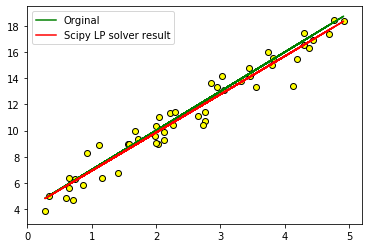

In [205]:
plt.plot(X, Y, c='green', label = 'Orginal')
plt.plot(X, X*a_scipy_lp+b_scipy_lp, c='red', label = 'Scipy LP solver result')
plt.scatter(X, Y_tilde, c='yellow', edgecolors='black')
plt.legend()
plt.show()

In [206]:
b = np.vstack((Y_with_outliers.reshape(N,1), Y_with_outliers.reshape(N,1)))
a1_scipy_lp,a2_scipy_lp,b1_scipy_lp,b2_scipy_lp = linprog(c, A_eq=A, b_eq=b, bounds=(0,None))['x'][:4]
a_scipy_lp,b_scipy_lp=a1_scipy_lp-a2_scipy_lp,b1_scipy_lp-b2_scipy_lp
a_scipy_lp,b_scipy_lp

(2.9248891761820763, 3.9860732102938345)

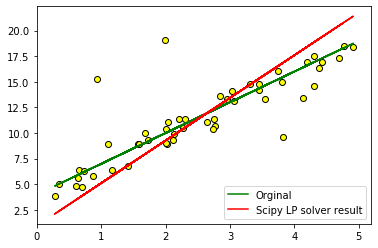

In [207]:
plt.plot(X, Y, c='green', label = 'Orginal')
plt.plot(X, X*a_scipy_lp_ol+b_scipy_lp_ol, c='red', label = 'Scipy LP solver result')
plt.scatter(X, Y_with_outliers, c='yellow', edgecolors='black')
plt.legend()
plt.show()

### Testing different a and b

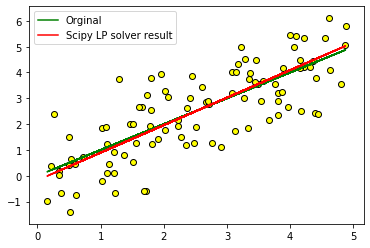

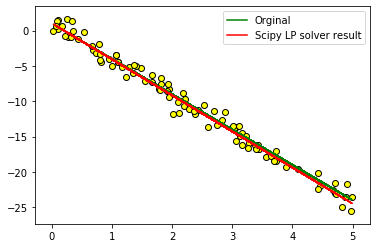

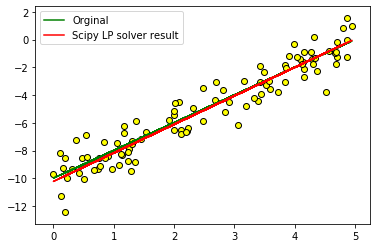

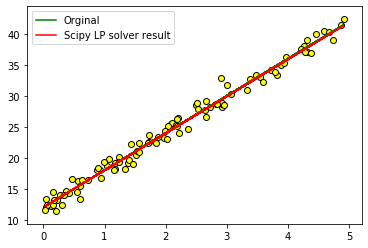

In [208]:
N = 100
for a,b in zip([1,-5,2,6],[0,1,-10,12]):
    X = np.random.rand(N)*5
    Y = a*X + b
    Y_tilde = Y + np.random.randn(N)
    A = np.vstack((
        np.hstack((X.reshape(N,1), X.reshape(N,1)*-1, np.ones((N,1)), np.ones((N,1))*-1, np.eye(N)*-1, np.eye(N), np.zeros((N,N)))),
        np.hstack((X.reshape(N,1), X.reshape(N,1)*-1, np.ones((N,1)), np.ones((N,1))*-1, np.eye(N), np.zeros((N,N)), np.eye(N)*-1))
    ))
    b = np.vstack((Y_tilde.reshape(N,1), Y_tilde.reshape(N,1)))
    c = np.vstack((np.zeros((4,1)), np.ones((N,1)), np.zeros((2*N,1))))
    a1_scipy_lp,a2_scipy_lp,b1_scipy_lp,b2_scipy_lp = linprog(c, A_eq=A, b_eq=b, bounds=(0,None))['x'][:4]
    a_scipy_lp,b_scipy_lp=a1_scipy_lp-a2_scipy_lp,b1_scipy_lp-b2_scipy_lp
    plt.plot(X, Y, c='green', label = 'Orginal')
    plt.plot(X, X*a_scipy_lp+b_scipy_lp, c='red', label = 'Scipy LP solver result')
    plt.scatter(X, Y_tilde, c='yellow', edgecolors='black')
    plt.legend()
    plt.show()
    

Linear Programming works quite well for this problem, but from my observations, outliers have a stronger impact on the result.